In [1]:
#do the essential imports
import inspect
import pandas as pd
import numpy as np
from gensim.scripts import glove2word2vec
from gensim.models import KeyedVectors
from gensim import matutils
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import multivariate_normal

from random import choice, shuffle
from random import randint

import networkx as nx
import jgraph
import matplotlib.pyplot as plt
from matplotlib import pylab
import community
%matplotlib inline

In [2]:
#get the ecommerce embeddings
embeddings_location  = "./complete_embedding"
# Loading our space twice since we will be changing the temp version
model                = KeyedVectors.load_word2vec_format(embeddings_location, binary=False)
temp                 = KeyedVectors.load_word2vec_format(embeddings_location, binary=False)

In [3]:
#plot the embeddings
def plot_projected_space(model, centers = None):
    num_points = 200
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000)
    #nemb = tf.nn.l2_normalize(self._w_in, 1)
    two_d_embeddings = tsne.fit_transform(model.syn0[1:num_points+1, :])
    if centers is not None:
        two_d_centers = tsne.fit_transform(centers)

    def plot(embeddings, labels, centers = None):
        assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
        pylab.figure(figsize=(15,15))  # in inches
        if centers is not None:
            for c in centers:
                x, y = c
                pylab.scatter(x, y)
                pylab.annotate("Cluster_middle!!!", xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
            pylab.scatter(x, y)
        for i, label in enumerate(labels):
            x, y = embeddings[i,:]
            pylab.scatter(x, y)
            pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        pylab.show()

    words = list(model.vocab.keys())[1:num_points+1]
    if centers is not None:
        plot(two_d_embeddings, words, two_d_centers)
    else:
        plot(two_d_embeddings, words)

/home/maulik/environments/matchnet_env/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


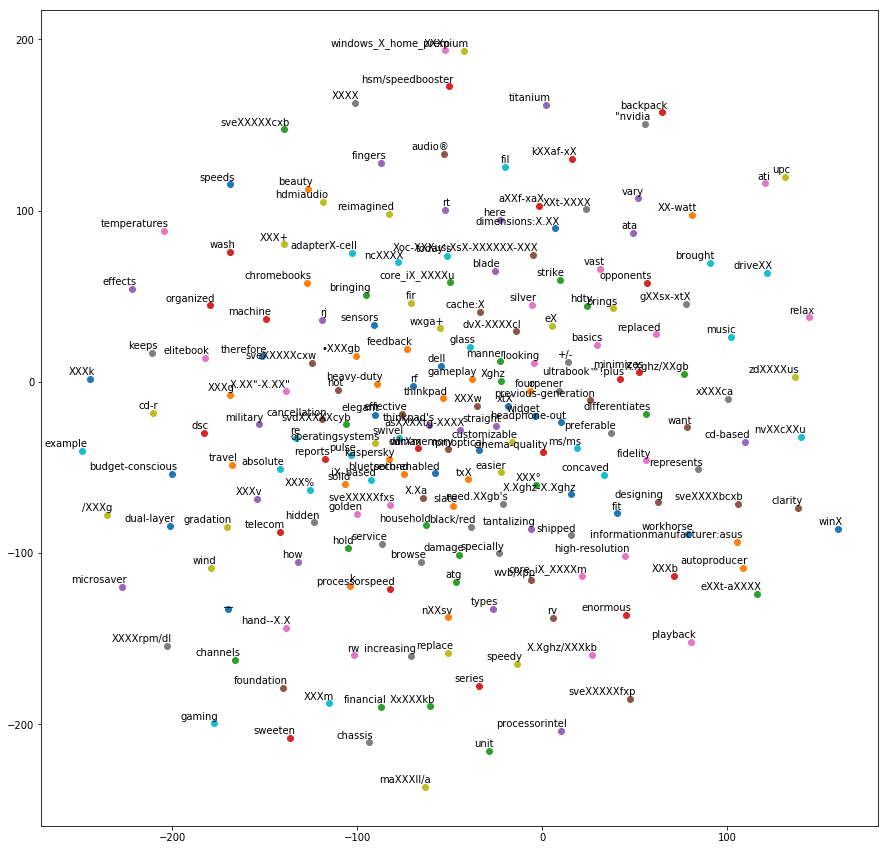

In [4]:
#actually plot the model
plot_projected_space(model)

In [20]:
def bootstrap_relations(word, topn=10, thresh=0.5):
    set_list = []
    error    = 0
    topn_candidates = [x[0] for x in model.similar_by_vector(word, topn) if x[0].lower() != word.lower()]
    for c in topn_candidates:
        entities = [word, c]
        temp_set = set()
        temp_set.add((word, c))
        cprime_candidates = [x[0] for x in model.similar_by_vector(c, topn) if x not in entities]
        for c_prime in cprime_candidates:
            entities.append(c_prime)
            w_prime = [x[0] for x in model.most_similar(positive=[word, c], negative=[c_prime])][0]
            vec1 = model[word]
            vec2 = model[c]
            vec3 = model[w_prime]
            vec4 = model[c_prime]
            if (1 - spatial.distance.cosine(vec1 - vec2, vec3 - vec4)) >= thresh:
                temp_set.add((c_prime, w_prime))
                error += np.sum(np.square((vec1 - vec2 + vec4) - vec3))
            else:
                break
        if len(temp_set) > 2:
            set_list.append((temp_set,error/len(temp_set)))
        error = 0
    set_list.sort(key=len, reverse=True)
    return set_list

            



In [64]:
top_k = 5
vocabulary = model.wv.vocab.keys()
vocabulary = vocabulary[:1000]
vocabulary = ['grey/black', 'brown', 'black/silver', 'brown', 'red', 'blue', 'charcoal']
output = []
count=0
total = len(vocabulary)
for word in vocabulary:
    count+=1
    if count%100==0:
        print(str(count) + " processed out of " + str(total))
    bootstraped = bootstrap_relations(word)
#     print(bootstraped)
    if len(bootstraped)<=0:
        continue
    if len(bootstraped)<top_k:
        my_top_k = len(bootstraped)
    else:
        my_top_k = top_k
    output.append(bootstraped[:my_top_k])
print(len(output))
# bootstraped = bootstrap_relations()
# print("bootstraping done.")
# bootstraped

1


/home/maulik/environments/matchnet_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [65]:
relations = set([])
for item in output:
    s, score = item[0][0], item[0][1]
    relations.update(s)
print("total relations are " + str(len(relations)))

total relations are 5


In [66]:
with open('relations_list.tsv','w') as f:
    for p in list(relations):
        f.write(str(p[0].encode('utf-8')) + "\t" + str(p[1].encode('utf-8')) + '\n')
        
print("relations written")

relations written


In [67]:
relations = list(relations)[:10]
with open('edge_list','w') as f:
    for p in list(relations):
        f.write(str(p[0].encode('utf-8')) + "," + str(p[1].encode('utf-8')) + '\n')

In [68]:
edges = nx.read_edgelist("edge_list", delimiter=',', nodetype=unicode)

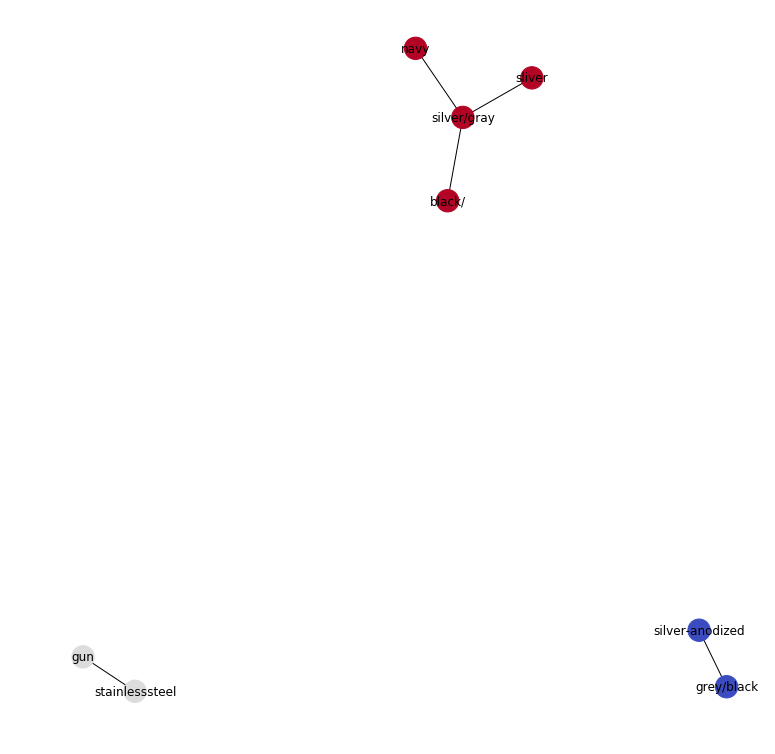

In [69]:
from community import community_louvain

part = community_louvain.best_partition(edges)
# part = community.best_partition(edges)
values = [part.get(node) for node in edges.nodes()]

nx.draw_spring(edges, cmap = plt.get_cmap('coolwarm'), node_color = values, node_size=500, with_labels=True)
pylab.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [74]:
#if your entity set is too low you can add the entity set from this expansion algorithm
def expand_set(words, threshhold = 0.6):
    numFeatures = 250
    priors = []
    
    for w in words:
        priors.append(model[w])
    
    
    # Create a mean vector for the "Prior Knowledge"
    vectors = np.vstack(priors).astype('float32')
    mean = matutils.unitvec(vectors.mean(axis=0)).astype('float32')

    cov = np.cov(np.array(vectors).T)
    #inv_cov = np.linalg.inv(cov)

    # Check strength of belonging to this group
    dists = np.dot(vectors, mean)
    
    #A combinatorial iteration over pairs 
    import itertools
    vecs = priors
    setlist = []

    for x in itertools.combinations(vecs,2):
        setlist.append(set(np.abs(x[0] - x[1]).argsort()[:numFeatures]))

    idx = list(set.intersection(*setlist))

    print('# Common fetures: ' + str(len(idx)))

    red_model = model.syn0norm[:,idx]
    temp.syn0norm = red_model
    
    # find similar
    final = set()
    for w in priors:
        for word in [x[0] for x in temp.similar_by_vector(w[idx], topn=1000, restrict_vocab=None)]:
            dist = np.dot(matutils.unitvec(model[word]).astype('float32'), mean)
            if dist >= threshhold:
#                 print(word, dist)
                final.add(word)
    return final
pre_expansion = list(zip(*relations))
# print(pre_expansion)
# print(pre_expansion)
expanded_A = expand_set(pre_expansion.pop())
expanded_B = expand_set(pre_expansion.pop())
print("Expanded A")
print(expanded_A)
print("Expanded B")
print(expanded_B)

[(u'black/', 'grey/black', u'navy', u'sliver', u'gun'), (u'silver/gray', u'silver-anodized', u'silver/gray', u'silver/gray', u'stainlesssteel')]
[(u'black/', 'grey/black', u'navy', u'sliver', u'gun'), (u'silver/gray', u'silver-anodized', u'silver/gray', u'silver/gray', u'stainlesssteel')]
# Common fetures: 150
# Common fetures: 150


/home/maulik/environments/matchnet_env/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
/home/maulik/environments/matchnet_env/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).


Expanded A
set([u'stainlesssteel', u'silver-anodized', u'silver/black', u'gun', u'black/slver', u'navy', u'brown/grey', u'silver/gray', u'black/', u'sliver', u'grey/black'])
Expanded B
set([u'psalwu-XXXXXX', u'intel_pentium_m', u'wqXXXua#aba', u'sXXXX-XXXXcbk', u'eXcXXua', u'forged', u'zXnX-XX-X.X-X-XXX', u'dvd-r/w', u'iXXXX-XXXXbk', u'nx.sheaa.XXX', u'vX-XXX', u'vpc-zXXXgx/s', u'uXXXt-sXXXX', u'XX-XXXXXX', u'uxXXa-dbXX', u'vgn-szXXXn/c', u'hm', u'vgn-nsXXXe/s', u'xgXXXua#aba', u'neomagic', u'fmXXXut#aba', u'xtXXXut#aba', u'npXXXxXb-aXXus', u'nu.shXaa.XXX', u'XXoaXXaXXXXXXXXuXXXq', u'windows_xp', u'txXXXXz', u'svfXXaXXcxb', u'iXXXX-XXXXobk', u'iXXr-XXXXslv', u'windows_X_professional', u'xpsXX-XXXXXslv', u'iXXr', u'silver-anodized', u'epXXXua#aba', u'svfXXXXXcxw', u'gun', u'sXXXca-rsiXtXX', u'nx.yXuaa.XXX', u'ecXXXua#aba', u'XXX-XXXXXX-XXX', u'aXXf-xaX', u'vgn-fwXXXj/b', u'xeXXXcXX-aXXus', u'svfXXXXXcxp', u'aXXe-xeX', u'etXXXua#aba', u'vgn-crXXXe/l', u'npXXXrXe-kXXub', u'wqXXXua', u'qua

In [75]:
with open('entities_a.tsv','w') as f:
    for e in list(expanded_A):
        f.write(str(e.encode('utf-8')) + '\n')
with open('entities_b.tsv','w') as f:
    for e in list(expanded_B):
        f.write(str(e.encode('utf-8')) + '\n')
print("written entities")

written entities
